In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.random.manual_seed(1337)
np.random.seed(1337)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

from lib.plotutility import set_eda_style
set_eda_style()

Using: cpu


Start length: 322091
Previous length: 198987
New length: 99456


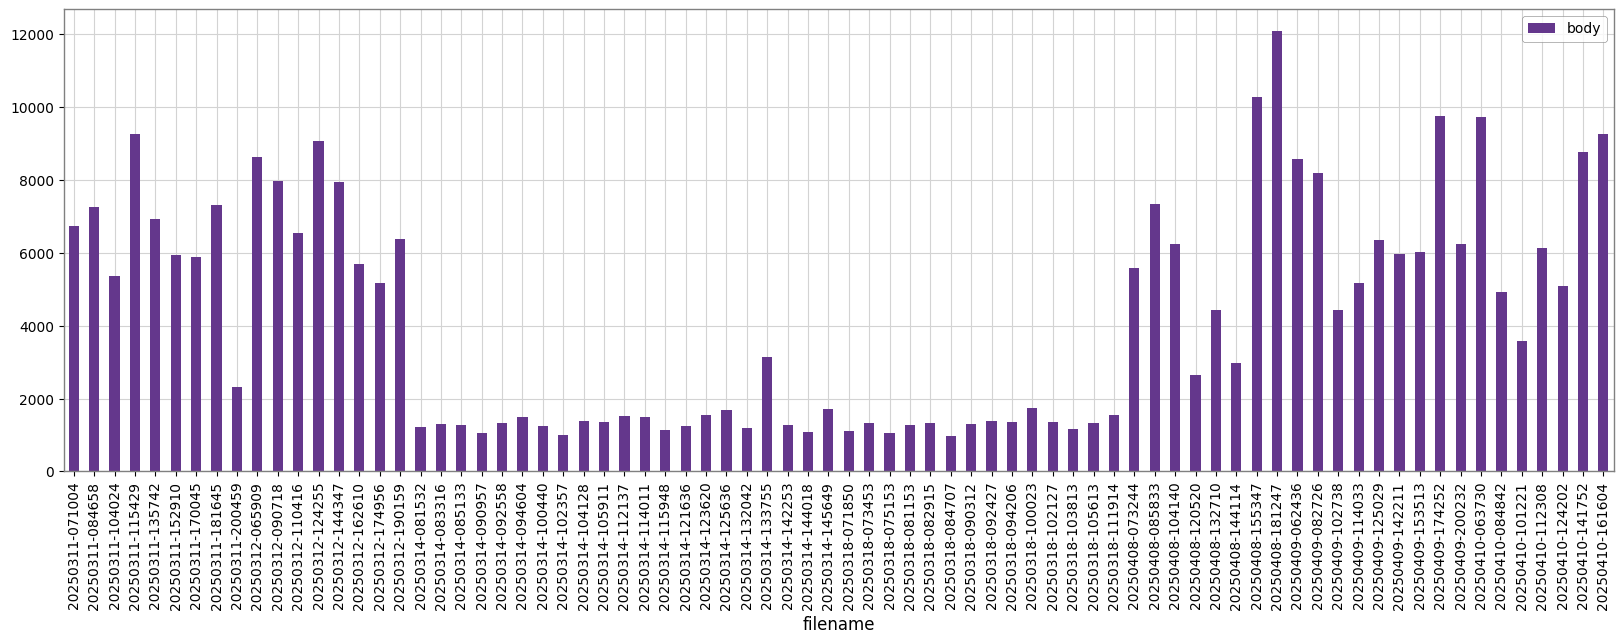

In [3]:
from lib.mitmproxyloader import load_mitm_packets_as_dataframe
from lib.mitmdataset import MitmProxyLogsDataset
from lib.mitmpairdataset import create_pairs_from_mitm_arrays, MitmProxyPairDataset

packet_dataframe = load_mitm_packets_as_dataframe("./data/")

def preprocess_dataframe(packet_dataframe):
    import json

    # Get filenames with entries < 4000
    filenames = packet_dataframe['filename'].value_counts()
    filenames = filenames[filenames < 1000]
    # filenames = filenames[filenames < 4000]

    # Remove filenames with entries < 4000
    packet_dataframe = packet_dataframe[~packet_dataframe['filename'].isin(filenames.index)]

    # Filter out all rows, where 'name' is not in 'body'
    packet_dataframe = packet_dataframe[packet_dataframe['body'].str.contains('name')]

    new_df = packet_dataframe.copy()

    for i, row in packet_dataframe.iterrows():
        body = row['body']
        if 'applyOtUpdate' in body:
            json_str = body.split('::')[1]

            # ------------------- Only take the body length ------------------ #
            # Choose this and outcomment the next section if you want the ablation study
            # new_df.at[i, 'bytes'] = len(body)
            # new_df.at[i, 'body'] = body

            # ----------------- Text wise content processing ----------------- #
            json_obj = json.loads(json_str)
            content = json_obj['args'][1]['op'][0]

            content_keys = content.keys()

            if 'i' in content_keys:
                new_df.at[i, 'bytes'] = len(content['i'])
            else:
                new_df.at[i, 'bytes'] = -len(content['d'])

            new_df.at[i, 'body'] = content
        else:
            new_df.at[i, 'body'] = "ACK"
            new_df.at[i, 'bytes'] = 0

    return new_df

print("Start length:", len(packet_dataframe))
packet_dataframe.groupby('filename').count().plot(kind='bar', y='body')
packet_dataframe = preprocess_dataframe(packet_dataframe)

# Drop all entries with 'ACK' in body
print("Previous length:", len(packet_dataframe))
packet_dataframe = packet_dataframe[packet_dataframe['body'] != 'ACK']
print("New length:", len(packet_dataframe))

In [4]:
print("Num labels:", len(packet_dataframe["filename"].unique()))

total_dataset = MitmProxyLogsDataset(packet_dataframe, training=True, chunk_size=64, scale_zero_to_one=True, apply_highpass=False, subtract_mean=False, scale_negative_separately=True)

def perform_k_split(k, dataset):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=k, shuffle=True)

    for train_index, test_index in kf.split(dataset):
        train_dataset = dataset[train_index]
        test_dataset = dataset[test_index]

        training_pairs, training_labels = create_pairs_from_mitm_arrays(train_dataset[0], train_dataset[1])
        testing_pairs, testing_labels = create_pairs_from_mitm_arrays(test_dataset[0], test_dataset[1])

        training_pair_dataset = MitmProxyPairDataset(training_pairs, training_labels)
        testing_pair_dataset = MitmProxyPairDataset(testing_pairs, testing_labels)

        yield {
            "train": training_pair_dataset,
            "test": testing_pair_dataset
        }

dataset_splits = list(perform_k_split(5, total_dataset))

Num labels: 75
Dataset Statistics
-------------------------------------------------------
Max value diff:   62930889000
Max value bytes:  29
Mean value diff:  2848719540
Mean value bytes: 3.7033361486486487
Std value diff:   4100478547
Std value bytes:  2.6873403451125877
Chunks per group: 4
-------------------------------------------------------


In [5]:
dataset = dataset_splits[0]
print("Train length:", len(dataset["train"]))
print("Test length:", len(dataset["test"]))

# Summarize time difference
tr_dataset = dataset["train"]
te_dataset = dataset["test"]

total_sum_us = 0

for i in range(len(tr_dataset)):
    datapoint = tr_dataset[i][0][0][0]
    datapoint = datapoint.cpu().detach().numpy()
    total_sum_us += np.sum(datapoint)

print("Total sum us:", (total_sum_us * MitmProxyLogsDataset.MAX_VALUE_DIFF) / 1000 / 1000 / 1000 / 60 / 60)

Train length: 480
Test length: 120
Total sum us: 24.918272


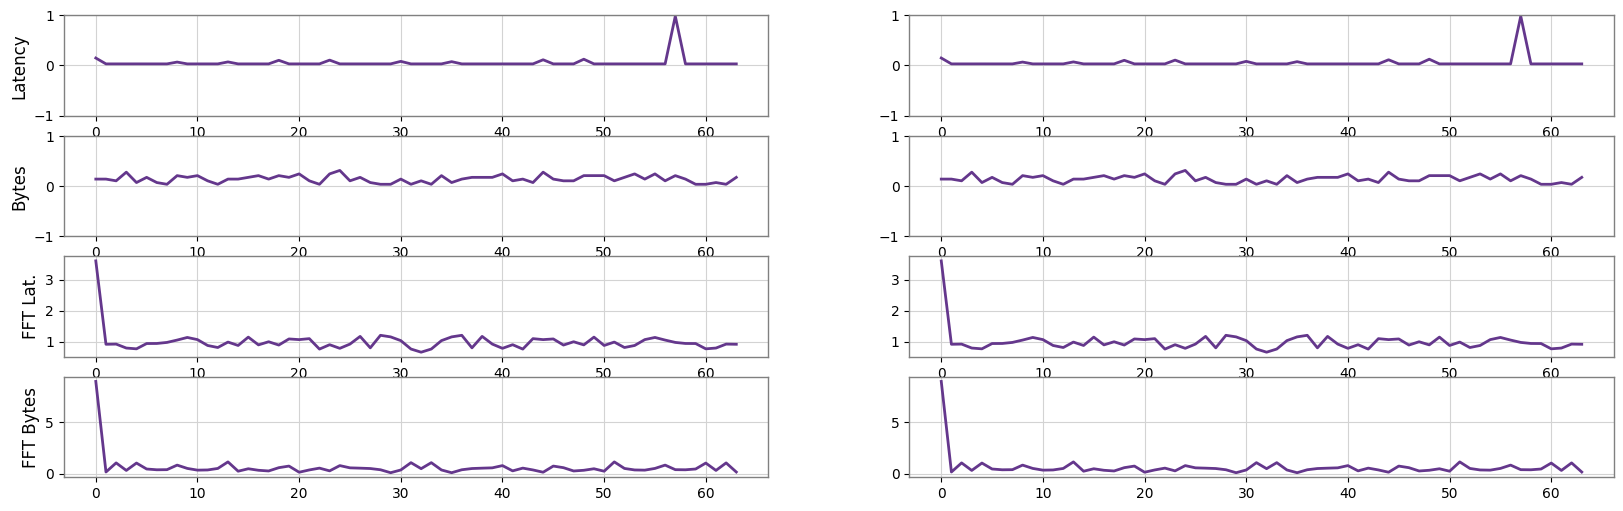

In [6]:
for i in range(1):
    dataset_splits[0]["test"].plot(i + 10, prepermute=(0, 1, 2))
    plt.show()

In [7]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

class SiameseNetwork(nn.Module):
    def __init__(self, backbone="resnet18"):
        '''
        Creates a siamese network with a network from torchvision.models as backbone.

            Parameters:
                    backbone (str): Options of the backbone networks can be found at https://pytorch.org/vision/stable/models.html
        '''

        super().__init__()

        # if backbone not in models.__dict__:
        #     raise Exception("No model named {} exists in torchvision.models.".format(backbone))

        # Create a backbone network from the pretrained models provided in torchvision.models
        # self.backbone = models.__dict__[backbone](pretrained=True, progress=True)
        self.backbone = models.resnet18()
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Get the number of features that are outputted by the last layer of backbone network.
        out_features = list(self.backbone.modules())[-1].out_features

        self.backbone.to(device)

        # Create an MLP (multi-layer perceptron) as the classification head.
        # Classifies if provided combined feature vector of the 2 images represent same player or different.
        self.cls_head = nn.Sequential(
            nn.Linear(out_features, 512),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 64),
            nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

        self.cls_head.to(device)

    def _weight_decay_hook(self, *_):
        for module in self.module:
            for param in module.parameters():
                param.grad = self.regularize(param)

    def regularize(self, param):
        return self.weight_decay * param

    def forward(self, x):
        '''
        Returns the similarity value between two images.

            Parameters:
                    x (torch.Tensor): shape=[b, 2, 4, 64]

            where b = batch size

            Returns:
                    output (torch.Tensor): shape=[b, 1], Similarity of each pair of images
        '''

        # x is in the shape of [b, 2, 4, 64]
        # Split into two images (img1 and img2) in the shape of [b, 4, 64]
        img1 = x[:, 0, :, :].unsqueeze(1)
        img2 = x[:, 1, :, :].unsqueeze(1)

        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)

        # Multiply (element-wise) the feature vectors of the two images together,
        # to generate a combined feature vector representing the similarity between the two.
        combined_features = feat1 * feat2
        # combined_features = torch.cat((feat1, feat2), dim=1)

        # Pass the combined feature vector through classification head to get similarity value in the range of 0 to 1.
        output = self.cls_head(combined_features)
        return output

model = SiameseNetwork()
model.to(device)
sample_input = torch.randn(64, 2, 64, 4)
sample_input = sample_input.to(device)
_ = model(sample_input)

In [8]:

def run_training(model, training_dataloader, testing_dataloader, optimizer, criterion, epochs=100):
    best_accuracy = 0
    best_model = None

    accuracies = []
    recalls = []
    precisions = []
    f1s = []

    for epoch in range(epochs):
        print("[{} / {}]".format(epoch, epochs))
        model.train()

        losses = []
        correct = 0
        total = 0

        # Training Loop Start
        for x, y in training_dataloader:
            x = x.to(device)
            y = y.to(device)

            prob = model(x)
            y = y.unsqueeze(1).float()

            loss = criterion(prob, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            correct += torch.count_nonzero(y == (prob > 0.5)).item()
            total += len(y)
        print("\tTraining: Loss={:.2f}\t Accuracy={:.2f}\t".format(sum(losses)/len(losses), correct / total))

        evaluation = run_evaluation(model, criterion, testing_dataloader)

        if evaluation["accuracy"] > best_accuracy:
            best_accuracy = evaluation["accuracy"]

            if best_accuracy > 0.65:
                # torch.save(model.state_dict(), f"best_model_{evaluation["accuracy"]}.pth")
                best_model = model.state_dict()

        accuracies.append(evaluation["accuracy"])
        recalls.append(evaluation["recall"])
        precisions.append(evaluation["precision"])
        f1s.append(evaluation["f1"])

        print("\tBest Accuracy:", best_accuracy)

    return {
        "accuracies": accuracies,
        "recalls": recalls,
        "precisions": precisions,
        "f1s": f1s,
        "best_model": best_model
    }

def run_evaluation(model, criterion, testing_dataloader):
    model.eval()

    losses = []
    correct = 0
    total = 0

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for x, y in testing_dataloader:
        x = x.to(device)
        y = y.to(device)

        prob = model(x)
        y = y.unsqueeze(1).float()
        loss = criterion(prob, y)

        losses.append(loss.item())
        correct += torch.count_nonzero(y == (prob > 0.5)).item()
        total += len(y)

        true_positive += torch.count_nonzero((y == 1) & (prob > 0.5)).item()
        true_negative += torch.count_nonzero((y == 0) & (prob < 0.5)).item()
        false_positive += torch.count_nonzero((y == 0) & (prob > 0.5)).item()
        false_negative += torch.count_nonzero((y == 1) & (prob < 0.5)).item()

    precision = 0
    recall = 0
    f1 = 0

    if true_positive + false_positive > 0:
        precision = true_positive / (true_positive + false_positive)

    if true_positive + false_negative > 0:
        recall = true_positive / (true_positive + false_negative)

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)

    val_loss = sum(losses)/max(1, len(losses))

    print("\tValidation: Loss={:.4f}\t Accuracy={:.4f}\t".format(val_loss, correct / total))
    print("\tPrecision: {:.4f}\t Recall: {:.4f}\t F1: {:.4f}".format(precision, recall, f1))

    return {
        "loss": val_loss,
        "accuracy": correct / total,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [9]:
split_results = []

for split in dataset_splits:
    model = SiameseNetwork()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = torch.nn.BCELoss()

    training_dataset = split["train"]
    testing_dataset = split["test"]

    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=256, shuffle=True)
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=256, shuffle=False)

    results = run_training(model, training_dataloader, testing_dataloader, optimizer, criterion, epochs=75)

    split_results.append(results)

[0 / 75]
	Training: Loss=0.69	 Accuracy=0.54	
	Validation: Loss=0.6930	 Accuracy=0.5000	
	Precision: 0.0000	 Recall: 0.0000	 F1: 0.0000
	Best Accuracy: 0.5
[1 / 75]
	Training: Loss=0.65	 Accuracy=0.67	
	Validation: Loss=0.6926	 Accuracy=0.5000	
	Precision: 0.5000	 Recall: 0.8500	 F1: 0.6296
	Best Accuracy: 0.5
[2 / 75]
	Training: Loss=0.61	 Accuracy=0.68	
	Validation: Loss=0.6950	 Accuracy=0.5000	
	Precision: 0.5000	 Recall: 0.9833	 F1: 0.6629
	Best Accuracy: 0.5
[3 / 75]
	Training: Loss=0.56	 Accuracy=0.75	
	Validation: Loss=0.7047	 Accuracy=0.5083	
	Precision: 0.5044	 Recall: 0.9500	 F1: 0.6590
	Best Accuracy: 0.5083333333333333
[4 / 75]
	Training: Loss=0.49	 Accuracy=0.78	
	Validation: Loss=0.6945	 Accuracy=0.6167	
	Precision: 0.5686	 Recall: 0.9667	 F1: 0.7160
	Best Accuracy: 0.6166666666666667
[5 / 75]
	Training: Loss=0.43	 Accuracy=0.83	
	Validation: Loss=0.7118	 Accuracy=0.6333	
	Precision: 0.5784	 Recall: 0.9833	 F1: 0.7284
	Best Accuracy: 0.6333333333333333
[6 / 75]
	Training:

In [10]:
best_epochs = [np.argmax(result["accuracies"]) for result in split_results]
best_accs = []
best_precs = []
best_recs = []
best_f1s = []

for i, result in enumerate(split_results):
    best_epoch = best_epochs[i]

    best_accs.append(result["accuracies"][best_epoch])
    best_precs.append(result["precisions"][best_epoch])
    best_recs.append(result["recalls"][best_epoch])
    best_f1s.append(result["f1s"][best_epoch])

print("Accuracy:")
print("Max:", np.max(best_accs), "Mean:", np.mean(best_accs), "Std:", np.std(best_accs))
print("Precision:")
print("Max:", np.max(best_precs), "Mean:", np.mean(best_precs), "Std:", np.std(best_precs))
print("Recall:")
print("Max:", np.max(best_recs), "Mean:", np.mean(best_recs), "Std:", np.std(best_recs))
print("F1:")
print("Max:", np.max(best_f1s), "Mean:", np.mean(best_f1s), "Std:", np.std(best_f1s))


Accuracy:
Max: 0.9166666666666666 Mean: 0.885 Std: 0.021343747458109495
Precision:
Max: 0.8709677419354839 Mean: 0.8432503651436501 Std: 0.021991457782726626
Recall:
Max: 1.0 Mean: 0.9466666666666667 Std: 0.03559026084010437
F1:
Max: 0.923076923076923 Mean: 0.8915286624599101 Std: 0.020525848252077646


In [13]:
best_models = [result["best_model"] for result in split_results]

In [14]:
def get_roc_for_model(model, fold):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    test_dataset = dataset_splits[fold]["test"]
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

    y_true = []
    y_scores = []

    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        prob = model(x)
        y_true.extend(y.cpu().numpy())
        y_scores.extend(prob.cpu().detach().numpy())
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    auc = roc_auc_score(y_true, y_scores)

    return fpr, tpr, thresholds, auc

fprs = []
tprs = []
aucs = []

for i in range(5):
    model = SiameseNetwork()
    model.load_state_dict(best_models[i])
    model.to(device)

    fpr, tpr, thresholds, score = get_roc_for_model(model, i)

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(score)

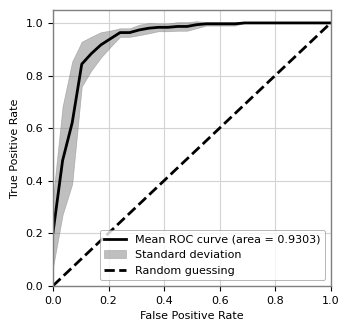

In [ ]:

def plot_auc_average(fprs, tprs, aucs):
    max_length = max([len(fpr) for fpr in fprs])

    mean_fpr = np.linspace(0, 1, max_length)
    mean_tpr = np.zeros_like(mean_fpr)

    std_tpr = np.zeros_like(mean_fpr)

    for fpr, tpr in zip(fprs, tprs):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        std_tpr += np.interp(mean_fpr, fpr, tpr) ** 2

    mean_tpr /= len(fprs)
    std_tpr = np.sqrt(std_tpr / len(fprs) - mean_tpr ** 2)

    mean_auc = np.mean(aucs)

    plt.plot(mean_fpr, mean_tpr, color='black', lw=2, label='Mean ROC curve (area = {:.4f})'.format(mean_auc))
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='gray', alpha=0.5, label="Standard deviation")
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label="Random guessing")

    plt.xlim([0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()

import matplotlib as mpl
from lib.plotutility import set_document_style

set_document_style(half_size=True, ratio='square')
plot_auc_average(fprs, tprs, aucs)
plt.show()

# plt.savefig("auc_average_siamese.pgf", bbox_inches='tight')